### Visual Explanation Example

c:\Users\ngcao\Documents\dev\uni\Thesis\AGCAM\BetterAGCAM\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[DEBUG] - sigmoid_mask.shape torch.Size([1, 224, 224])
[DEBUG] - sigmoid_mask tensor([[[0.0954, 0.0954, 0.0954,  ..., 0.2013, 0.2013, 0.2013],
         [0.0954, 0.0954, 0.0954,  ..., 0.2013, 0.2013, 0.2013],
         [0.0954, 0.0954, 0.0954,  ..., 0.2013, 0.2013, 0.2013],
         ...,
         [0.1221, 0.1221, 0.1221,  ..., 0.1176, 0.1176, 0.1176],
         [0.1221, 0.1221, 0.1221,  ..., 0.1176, 0.1176, 0.1176],
         [0.1221, 0.1221, 0.1221,  ..., 0.1176, 0.1176, 0.1176]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


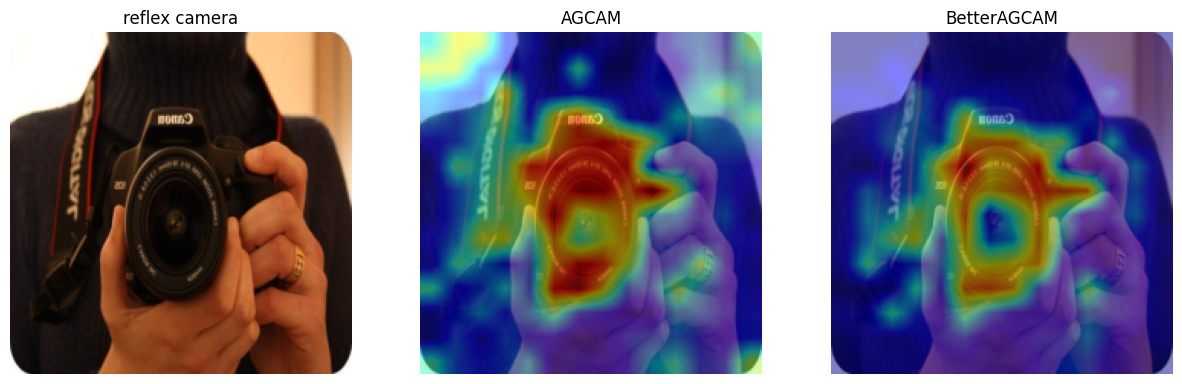

In [1]:
#generate heatmap for given image.
#If you want to generate heatmap for other image, change IMAGE_PATH

import torch
import torchvision.transforms as transforms
import numpy as np
import PIL
import matplotlib.pyplot as plt
from Datasets.ILSVRC_classes import classes
import torch.utils.model_zoo as model_zoo

#models
import Methods.AGCAM.ViT_for_AGCAM as ViT_Ours
import timm
from Methods.LRP.ViT_LRP import vit_base_patch16_224 as LRP_vit_base_patch16_224

#methods
from Methods.AGCAM.AGCAM import AGCAM, BetterAGCAM
from Methods.LRP.ViT_explanation_generator import LRP
from Methods.AttentionRollout.AttentionRollout import VITAttentionRollout

MODEL = 'vit_base_patch16_224'
IMG_SIZE=224
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#Select Image which you want to generate a heatmap for.
# IMAGE_PATH = "samples/ILSVRC2012_val_00000125.jpeg"
IMAGE_PATH = "samples/ILSVRC2012_val_00001854.jpeg"


# Load the model parameter provided by the Timm library
state_dict = model_zoo.load_url('https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_p16_224-80ecf9dd.pth', progress=False, map_location=device)

# Image transformation for ImageNet ILSVRC 2012.
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

# For convert the input image into original distribution to display
unnormalize = transforms.Compose([
    transforms.Normalize([0., 0., 0.], [1/0.5, 1/0.5, 1/0.5]),
    transforms.Normalize([-0.5, -0.5, -0.5], [1., 1., 1.,])
])


# Open the input image and transform
image = PIL.Image.open(IMAGE_PATH)
image = transform(image)
image = image.unsqueeze(0).to(device)

class_num=1000

# Models and Methods
ours_model = ViT_Ours.create_model(MODEL, pretrained=True, num_classes=class_num).to(device)
ours_model.load_state_dict(state_dict, strict=True)
ours_model.eval()
ours_method = AGCAM(ours_model)


with torch.enable_grad():
    # Generate heatmap of our method
    ours_method = AGCAM(ours_model)
    prediction, ours_heatmap = ours_method.generate(image)
    ours_heatmap = transforms.Resize((224, 224))(ours_heatmap[0])
    ours_heatmap = (ours_heatmap - ours_heatmap.min())/(ours_heatmap.max()-ours_heatmap.min())
    ours_heatmap = ours_heatmap.detach().cpu().numpy()
    ours_heatmap = np.transpose(ours_heatmap, (1, 2, 0))
    
    ours_method = BetterAGCAM(ours_model)
    prediction, sigmoid_heatmap = ours_method.generate(image)
    sigmoid_heatmap = transforms.Resize((224, 224))(sigmoid_heatmap[0])
    print("[DEBUG] - sigmoid_mask.shape", sigmoid_heatmap.shape)
    print("[DEBUG] - sigmoid_mask", sigmoid_heatmap)
    sigmoid_heatmap = (sigmoid_heatmap - sigmoid_heatmap.min())/(sigmoid_heatmap.max()-sigmoid_heatmap.min())
    sigmoid_heatmap = sigmoid_heatmap.detach().cpu().numpy()
    sigmoid_heatmap = np.transpose(sigmoid_heatmap, (1, 2, 0))


    # Display the results
    image = unnormalize(image)
    image = image.detach().cpu().numpy()[0]
    image = np.transpose(image, (1, 2, 0))
    fig, axs = plt.subplots(1,3, figsize=(15, 70))
    axs[0].set_title(classes[prediction.item()])
    axs[0].imshow(image)
    axs[0].axis('off')
    
    axs[1].set_title('AGCAM')
    axs[1].imshow(image)
    axs[1].imshow(ours_heatmap, cmap='jet', alpha=0.5)
    axs[1].axis('off')
    
    axs[2].set_title('BetterAGCAM')
    axs[2].imshow(image)
    axs[2].imshow(sigmoid_heatmap, cmap='jet', alpha=0.5)
    axs[2].axis('off')

In [ ]:


#Select Image which you want to generate a heatmap for.
IMAGE_PATH = "samples/ILSVRC2012_val_00001372.jpeg"

image = PIL.Image.open(IMAGE_PATH)
image = transform(image)
image = image.unsqueeze(0).to(device)


with torch.enable_grad():
    # Generate heatmap of our method
    prediction, ours_heatmap = ours_method.generate(image)
    ours_heatmap = transforms.Resize((224, 224))(ours_heatmap[0])
    ours_heatmap = (ours_heatmap - ours_heatmap.min())/(ours_heatmap.max()-ours_heatmap.min())
    ours_heatmap = ours_heatmap.detach().cpu().numpy()
    ours_heatmap = np.transpose(ours_heatmap, (1, 2, 0))
    
    # Generate heatmap of LRP-based method
    _, lrp_heatmap = lrp_method.generate(image)
    lrp_heatmap = transforms.Resize((224, 224))(lrp_heatmap[0])
    lrp_heatmap = (lrp_heatmap - lrp_heatmap.min())/(lrp_heatmap.max()-lrp_heatmap.min())
    lrp_heatmap = lrp_heatmap.detach().cpu().numpy()
    lrp_heatmap = np.transpose(lrp_heatmap, (1, 2, 0))

    # Generate heatmap of Attention Rollout
    _, rollout_heatmap = rollout_method.generate(image)
    rollout_heatmap = transforms.Resize((224, 224))(rollout_heatmap[0])
    rollout_heatmap = (rollout_heatmap - rollout_heatmap.min())/(rollout_heatmap.max()-rollout_heatmap.min())
    rollout_heatmap = rollout_heatmap.detach().cpu().numpy()
    rollout_heatmap = np.transpose(rollout_heatmap, (1, 2, 0))

    # Display the results
    image = unnormalize(image)
    image = image.detach().cpu().numpy()[0]
    image = np.transpose(image, (1, 2, 0))
    fig, axs = plt.subplots(1,4, figsize=(15, 70))
    axs[0].set_title(classes[prediction.item()])
    axs[0].imshow(image)
    axs[0].axis('off')
    
    axs[1].set_title('Ours')
    axs[1].imshow(image)
    axs[1].imshow(ours_heatmap, cmap='jet', alpha=0.5)
    axs[1].axis('off')
    
    axs[2].set_title('LRP-based')
    axs[2].imshow(image)
    axs[2].imshow(lrp_heatmap, cmap='jet', alpha=0.5)
    axs[2].axis('off')

    axs[3].set_title('Attention Rollout')
    axs[3].imshow(image)
    axs[3].imshow(rollout_heatmap, cmap='jet', alpha=0.5)
    axs[3].axis('off')
    
    


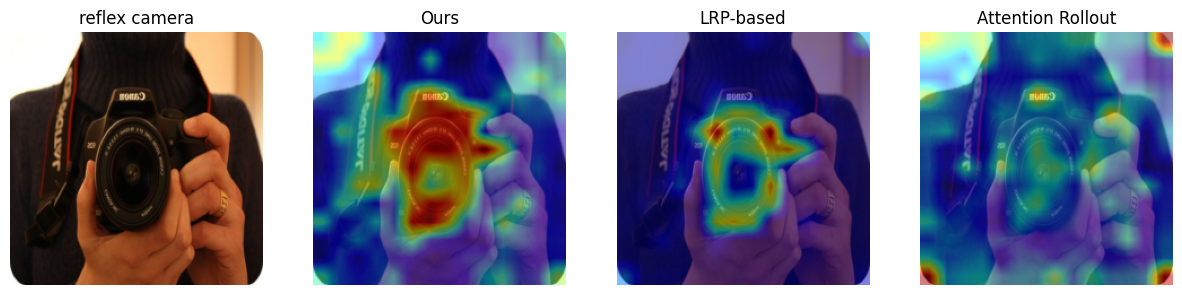

In [ ]:


#Select Image which you want to generate a heatmap for.
IMAGE_PATH = "samples/ILSVRC2012_val_00001854.jpeg"

image = PIL.Image.open(IMAGE_PATH)
image = transform(image)
image = image.unsqueeze(0).to(device)

    
   
    
    
with torch.enable_grad():
    # Generate heatmap of our method
    prediction, ours_heatmap = ours_method.generate(image)
    ours_heatmap = transforms.Resize((224, 224))(ours_heatmap[0])
    ours_heatmap = (ours_heatmap - ours_heatmap.min())/(ours_heatmap.max()-ours_heatmap.min())
    ours_heatmap = ours_heatmap.detach().cpu().numpy()
    ours_heatmap = np.transpose(ours_heatmap, (1, 2, 0))

    # Generate heatmap of LRP-based method
    _, lrp_heatmap = lrp_method.generate(image)
    lrp_heatmap = transforms.Resize((224, 224))(lrp_heatmap[0])
    lrp_heatmap = (lrp_heatmap - lrp_heatmap.min())/(lrp_heatmap.max()-lrp_heatmap.min())
    lrp_heatmap = lrp_heatmap.detach().cpu().numpy()
    lrp_heatmap = np.transpose(lrp_heatmap, (1, 2, 0))

    # Generate heatmap of Attention Rollout
    _, rollout_heatmap = rollout_method.generate(image)
    rollout_heatmap = transforms.Resize((224, 224))(rollout_heatmap[0])
    rollout_heatmap = (rollout_heatmap - rollout_heatmap.min())/(rollout_heatmap.max()-rollout_heatmap.min())
    rollout_heatmap = rollout_heatmap.detach().cpu().numpy()
    rollout_heatmap = np.transpose(rollout_heatmap, (1, 2, 0))

    # Display the results
    image = unnormalize(image)
    image = image.detach().cpu().numpy()[0]
    image = np.transpose(image, (1, 2, 0))
    fig, axs = plt.subplots(1,4, figsize=(15, 70))
    axs[0].set_title(classes[prediction.item()])
    axs[0].imshow(image)
    axs[0].axis('off')
    
    axs[1].set_title('Ours')
    axs[1].imshow(image)
    axs[1].imshow(ours_heatmap, cmap='jet', alpha=0.5)
    axs[1].axis('off')
    
    axs[2].set_title('LRP-based')
    axs[2].imshow(image)
    axs[2].imshow(lrp_heatmap, cmap='jet', alpha=0.5)
    axs[2].axis('off')

    axs[3].set_title('Attention Rollout')
    axs[3].imshow(image)
    axs[3].imshow(rollout_heatmap, cmap='jet', alpha=0.5)
    axs[3].axis('off')
    
    


### Class-specific Explanation

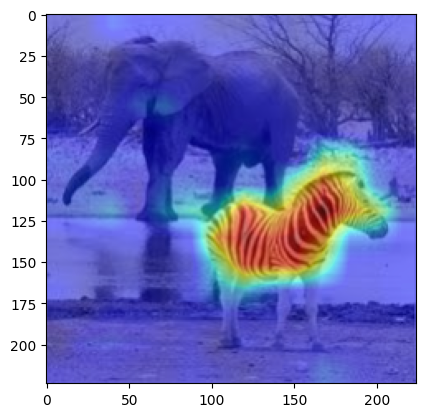

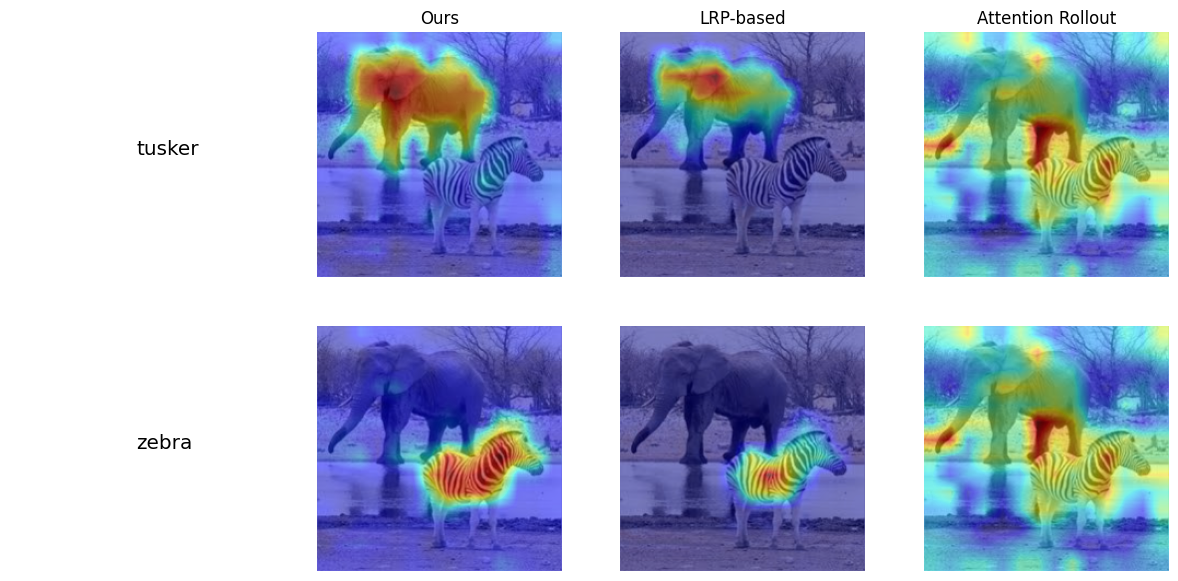

In [ ]:
# Select Image which you want to generate a heatmap for.
IMAGE_PATH = "samples/tusker_zebra.png"
# The class number for which the methods produce the heatmap
class1=101
class2=340
image = PIL.Image.open(IMAGE_PATH)
image = transform(image)
image = image.unsqueeze(0).to(device)

    

with torch.enable_grad():
    # Generate heatmap of our method
    _, ours_1 = ours_method.generate(image, class1)
    ours_1 = transforms.Resize((224, 224))(ours_1[0])
    ours_1 = (ours_1 - ours_1.min())/(ours_1.max()-ours_1.min())
    ours_1 = ours_1.detach().cpu().numpy()
    ours_1 = np.transpose(ours_1, (1, 2, 0))
    _, ours_2 = ours_method.generate(image, class2)
    ours_2 = transforms.Resize((224, 224))(ours_2[0])
    ours_2 = (ours_2 - ours_2.min())/(ours_2.max()-ours_2.min())
    ours_2 = ours_2.detach().cpu().numpy()
    ours_2 = np.transpose(ours_2, (1, 2, 0))

    # Generate heatmap of LRP-based method
    _, lrp_1 = lrp_method.generate(image, class1)
    lrp_1 = transforms.Resize((224, 224))(lrp_1[0])
    lrp_1 = (lrp_1 - lrp_1.min())/(lrp_1.max()-lrp_1.min())
    lrp_1 = lrp_1.detach().cpu().numpy()
    lrp_1 = np.transpose(lrp_1, (1, 2, 0))
    _, lrp_2 = lrp_method.generate(image, class2)
    lrp_2 = transforms.Resize((224, 224))(lrp_2[0])
    lrp_2 = (lrp_2 - lrp_2.min())/(lrp_2.max()-lrp_2.min())
    lrp_2 = lrp_2.detach().cpu().numpy()
    lrp_2 = np.transpose(lrp_2, (1, 2, 0))

    # Generate heatmap of Attention Rollout
    # Attention Rollout cannot produce a class-specific visualization.
    _, rollout_heatmap = rollout_method.generate(image)
    rollout_heatmap = transforms.Resize((224, 224))(rollout_heatmap[0])
    rollout_heatmap = (rollout_heatmap - rollout_heatmap.min())/(rollout_heatmap.max()-rollout_heatmap.min())
    rollout_heatmap = rollout_heatmap.detach().cpu().numpy()
    rollout_heatmap = np.transpose(rollout_heatmap, (1, 2, 0))
    
    # Display the results
    image = unnormalize(image)
    image = image.detach().cpu().numpy()[0]
    image = np.transpose(image, (1, 2, 0))
    plt.axis('off')
    plt.imshow(image)
    plt.imshow(ours_1, cmap='jet', alpha=0.5)
    plt.savefig("C:\\임새봄\\논문\\poster\\image1.png")
    plt.imshow(image)
    plt.imshow(ours_2, cmap='jet', alpha=0.5)
    plt.savefig("C:\\임새봄\\논문\\poster\\image2.png")



    fig, axs = plt.subplots(2,4, figsize=(15, 7))
    axs[0,0].text(0.5, 0.5, classes[class1], fontsize='x-large')
    axs[0,0].axis('off')

    axs[0,1].set_title('Ours')
    axs[0,1].imshow(image)
    axs[0,1].imshow(ours_1, cmap='jet', alpha=0.5)
    axs[0,1].axis('off')


    axs[0,2].set_title('LRP-based')
    axs[0,2].imshow(image)
    axs[0,2].imshow(lrp_1, cmap='jet', alpha=0.5)
    axs[0,2].axis('off')

    axs[0,3].set_title('Attention Rollout')
    axs[0,3].imshow(image)
    axs[0,3].imshow(rollout_heatmap, cmap='jet', alpha=0.5)
    axs[0,3].axis('off')

    axs[1,0].text(0.5, 0.5, classes[class2], fontsize='x-large')
    axs[1,0].axis('off')

    axs[1,1].imshow(image)
    axs[1,1].imshow(ours_2, cmap='jet', alpha=0.5)
    axs[1,1].axis('off')

    axs[1,2].imshow(image)
    axs[1,2].imshow(lrp_2, cmap='jet', alpha=0.5)
    axs[1,2].axis('off')

    axs[1,3].imshow(image)
    axs[1,3].imshow(rollout_heatmap, cmap='jet', alpha=0.5)
    axs[1,3].axis('off')

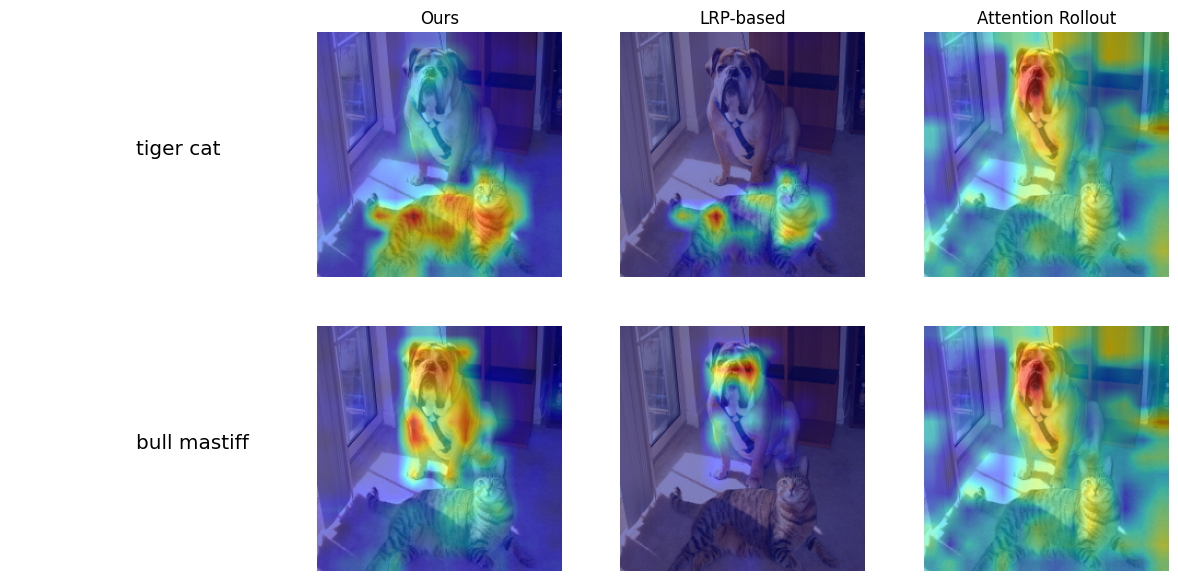

In [ ]:
# Select Image which you want to generate a heatmap for.
IMAGE_PATH = "samples/catdog.png"
# The class number for which the methods produce the heatmap
class1=282
class2=243
image = PIL.Image.open(IMAGE_PATH)
image = transform(image)
image = image.unsqueeze(0).to(device)
    

with torch.enable_grad():
    # Generate heatmap of our method
    _, ours_1 = ours_method.generate(image, class1)
    ours_1 = transforms.Resize((224, 224))(ours_1[0])
    ours_1 = (ours_1 - ours_1.min())/(ours_1.max()-ours_1.min())
    ours_1 = ours_1.detach().cpu().numpy()
    ours_1 = np.transpose(ours_1, (1, 2, 0))
    _, ours_2 = ours_method.generate(image, class2)
    ours_2 = transforms.Resize((224, 224))(ours_2[0])
    ours_2 = (ours_2 - ours_2.min())/(ours_2.max()-ours_2.min())
    ours_2 = ours_2.detach().cpu().numpy()
    ours_2 = np.transpose(ours_2, (1, 2, 0))

    # Generate heatmap of LRP-based method
    _, lrp_1 = lrp_method.generate(image, class1)
    lrp_1 = transforms.Resize((224, 224))(lrp_1[0])
    lrp_1 = (lrp_1 - lrp_1.min())/(lrp_1.max()-lrp_1.min())
    lrp_1 = lrp_1.detach().cpu().numpy()
    lrp_1 = np.transpose(lrp_1, (1, 2, 0))
    _, lrp_2 = lrp_method.generate(image, class2)
    lrp_2 = transforms.Resize((224, 224))(lrp_2[0])
    lrp_2 = (lrp_2 - lrp_2.min())/(lrp_2.max()-lrp_2.min())
    lrp_2 = lrp_2.detach().cpu().numpy()
    lrp_2 = np.transpose(lrp_2, (1, 2, 0))

    # Generate heatmap of Attention Rollout
    _, rollout_heatmap = rollout_method.generate(image)
    rollout_heatmap = transforms.Resize((224, 224))(rollout_heatmap[0])
    rollout_heatmap = (rollout_heatmap - rollout_heatmap.min())/(rollout_heatmap.max()-rollout_heatmap.min())
    rollout_heatmap = rollout_heatmap.detach().cpu().numpy()
    rollout_heatmap = np.transpose(rollout_heatmap, (1, 2, 0))
    
    # Display the results
    image = unnormalize(image)
    image = image.detach().cpu().numpy()[0]
    image = np.transpose(image, (1, 2, 0))
    
    fig, axs = plt.subplots(2,4, figsize=(15, 7))
    axs[0,0].text(0.5, 0.5, classes[class1], fontsize='x-large')
    axs[0,0].axis('off')

    axs[0,1].set_title('Ours')
    axs[0,1].imshow(image)
    axs[0,1].imshow(ours_1, cmap='jet', alpha=0.5)
    axs[0,1].axis('off')


    axs[0,2].set_title('LRP-based')
    axs[0,2].imshow(image)
    axs[0,2].imshow(lrp_1, cmap='jet', alpha=0.5)
    axs[0,2].axis('off')

    axs[0,3].set_title('Attention Rollout')
    axs[0,3].imshow(image)
    axs[0,3].imshow(rollout_heatmap, cmap='jet', alpha=0.5)
    axs[0,3].axis('off')

    axs[1,0].text(0.5, 0.5, classes[class2], fontsize='x-large')
    axs[1,0].axis('off')

    axs[1,1].imshow(image)
    axs[1,1].imshow(ours_2, cmap='jet', alpha=0.5)
    axs[1,1].axis('off')

    axs[1,2].imshow(image)
    axs[1,2].imshow(lrp_2, cmap='jet', alpha=0.5)
    axs[1,2].axis('off')

    axs[1,3].imshow(image)
    axs[1,3].imshow(rollout_heatmap, cmap='jet', alpha=0.5)
    axs[1,3].axis('off')

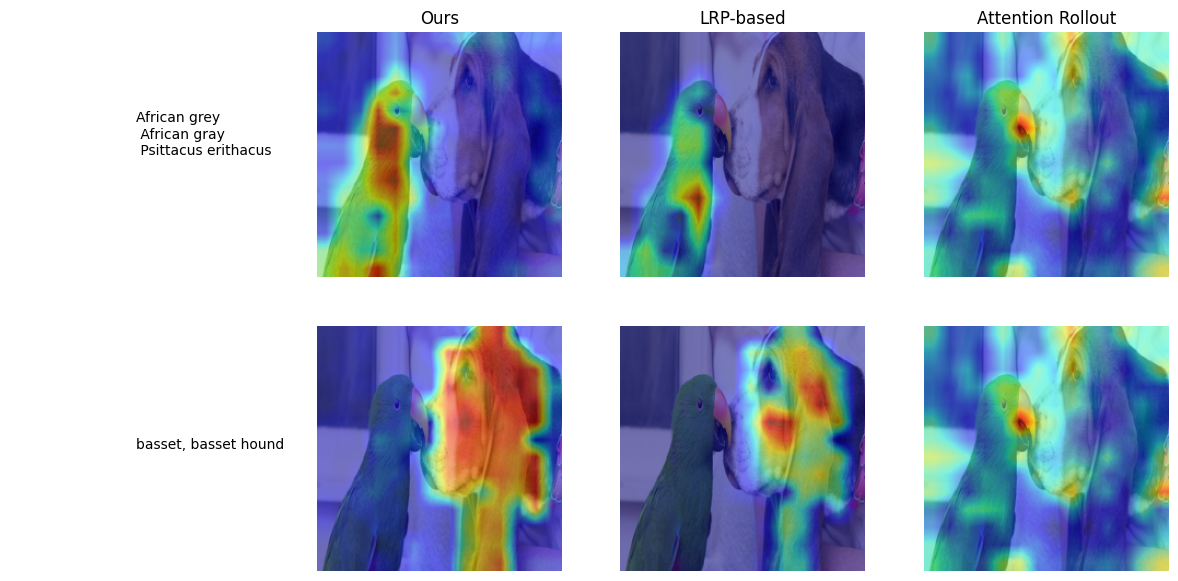

In [ ]:
# Select Image which you want to generate a heatmap for.
IMAGE_PATH = "samples/dogbird.png"
# The class number for which the methods produce the heatmap
class1=87
class2=161
image = PIL.Image.open(IMAGE_PATH)
image = transform(image)
image = image.unsqueeze(0).to(device)
  
    
with torch.enable_grad():
    # Generate heatmap of our methods
    _, ours_1 = ours_method.generate(image, class1)
    ours_1 = transforms.Resize((224, 224))(ours_1[0])
    ours_1 = (ours_1 - ours_1.min())/(ours_1.max()-ours_1.min())
    ours_1 = ours_1.detach().cpu().numpy()
    ours_1 = np.transpose(ours_1, (1, 2, 0))
    _, ours_2 = ours_method.generate(image, class2)
    ours_2 = transforms.Resize((224, 224))(ours_2[0])
    ours_2 = (ours_2 - ours_2.min())/(ours_2.max()-ours_2.min())
    ours_2 = ours_2.detach().cpu().numpy()
    ours_2 = np.transpose(ours_2, (1, 2, 0))

    # Generate heatmap of LRP-based method
    _, lrp_1 = lrp_method.generate(image, class1)
    lrp_1 = transforms.Resize((224, 224))(lrp_1[0])
    lrp_1 = (lrp_1 - lrp_1.min())/(lrp_1.max()-lrp_1.min())
    lrp_1 = lrp_1.detach().cpu().numpy()
    lrp_1 = np.transpose(lrp_1, (1, 2, 0))
    _, lrp_2 = lrp_method.generate(image, class2)
    lrp_2 = transforms.Resize((224, 224))(lrp_2[0])
    lrp_2 = (lrp_2 - lrp_2.min())/(lrp_2.max()-lrp_2.min())
    lrp_2 = lrp_2.detach().cpu().numpy()
    lrp_2 = np.transpose(lrp_2, (1, 2, 0))

    # Generate heatmap of Attention Rollout
    _, rollout_heatmap = rollout_method.generate(image)
    rollout_heatmap = transforms.Resize((224, 224))(rollout_heatmap[0])
    rollout_heatmap = (rollout_heatmap - rollout_heatmap.min())/(rollout_heatmap.max()-rollout_heatmap.min())
    rollout_heatmap = rollout_heatmap.detach().cpu().numpy()
    rollout_heatmap = np.transpose(rollout_heatmap, (1, 2, 0))
    
    # Display the results
    image = unnormalize(image)
    image = image.detach().cpu().numpy()[0]
    image = np.transpose(image, (1, 2, 0))
    
    fig, axs = plt.subplots(2,4, figsize=(15, 7))
    axs[0,0].text(0.5, 0.5, classes[class1].split(',')[0] + '\n' + classes[class1].split(',')[1]+'\n'+classes[class1].split(',')[2], )
    axs[0,0].axis('off')

    axs[0,1].set_title('Ours')
    axs[0,1].imshow(image)
    axs[0,1].imshow(ours_1, cmap='jet', alpha=0.5)
    axs[0,1].axis('off')


    axs[0,2].set_title('LRP-based')
    axs[0,2].imshow(image)
    axs[0,2].imshow(lrp_1, cmap='jet', alpha=0.5)
    axs[0,2].axis('off')

    axs[0,3].set_title('Attention Rollout')
    axs[0,3].imshow(image)
    axs[0,3].imshow(rollout_heatmap, cmap='jet', alpha=0.5)
    axs[0,3].axis('off')

    axs[1,0].text(0.5, 0.5, classes[class2], )
    axs[1,0].axis('off')

    axs[1,1].imshow(image)
    axs[1,1].imshow(ours_2, cmap='jet', alpha=0.5)
    axs[1,1].axis('off')

    axs[1,2].imshow(image)
    axs[1,2].imshow(lrp_2, cmap='jet', alpha=0.5)
    axs[1,2].axis('off')

    axs[1,3].imshow(image)
    axs[1,3].imshow(rollout_heatmap, cmap='jet', alpha=0.5)
    axs[1,3].axis('off')